In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stochastic.processes import FractionalBrownianMotion
from utils import *

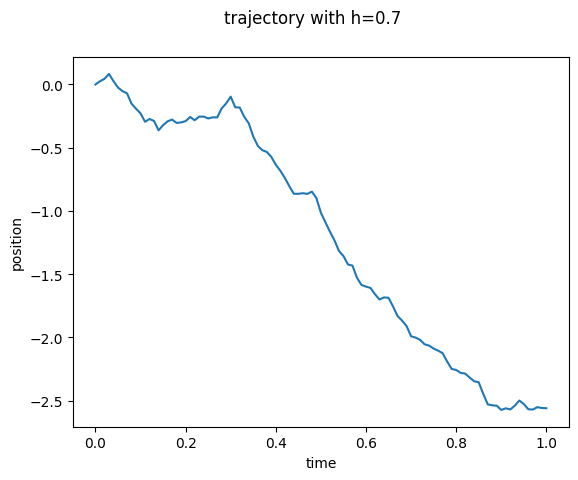

In [2]:
#Quick sanity to check to show a sample relization

f = FractionalBrownianMotion(hurst=0.7, t=1)
# Generate a fBm realization
fbm_sample = f.sample(100)
# Get the times associated with the fBm
t_values = f.times(100)
plt.plot(t_values[:10000], fbm_sample[:10000])
plt.xlabel('time')
plt.ylabel('position')
plt.suptitle("trajectory with h=0.7")
plt.show()

# Model training:

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [4]:
N_SIMS=60000  #Number of simulations
trajectory_length=100   #Number of samples per simulation
batch_size=10
learning_rate=1e-3


X_train, Y_train, X_test, Y_test = generate_dataset(N_SIMS, trajectory_length)

train_data=SimulationDatset(X_train, Y_train)
train_loader=DataLoader(train_data, batch_size=batch_size)

test_data=SimulationDatset(X_test, Y_test)
test_loader=DataLoader(test_data, batch_size=batch_size)


model=DeepBrownianEncoder(embedding_dim=30, num_layers=1, num_heads=2).to(device)
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Simulations Generated: 0
Simulations Generated: 10000
Simulations Generated: 20000
Simulations Generated: 30000
Simulations Generated: 40000
Simulations Generated: 50000


In [5]:
epochs = 5
losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer, device)
    losses += (loss)
    DatasetMAE(test_loader, model, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.614401  [   10/42000]
loss: 0.137063  [ 1010/42000]
loss: 0.077297  [ 2010/42000]
loss: 0.176446  [ 3010/42000]
loss: 0.227622  [ 4010/42000]
loss: 0.175469  [ 5010/42000]
loss: 0.086723  [ 6010/42000]
loss: 0.066636  [ 7010/42000]
loss: 0.041184  [ 8010/42000]
loss: 0.043319  [ 9010/42000]
loss: 0.050687  [10010/42000]
loss: 0.038216  [11010/42000]
loss: 0.030496  [12010/42000]
loss: 0.061586  [13010/42000]
loss: 0.040183  [14010/42000]
loss: 0.038878  [15010/42000]
loss: 0.035306  [16010/42000]
loss: 0.073768  [17010/42000]
loss: 0.056893  [18010/42000]
loss: 0.023559  [19010/42000]
loss: 0.012073  [20010/42000]
loss: 0.016036  [21010/42000]
loss: 0.029150  [22010/42000]
loss: 0.058727  [23010/42000]
loss: 0.044797  [24010/42000]
loss: 0.032273  [25010/42000]
loss: 0.052524  [26010/42000]
loss: 0.044377  [27010/42000]
loss: 0.058203  [28010/42000]
loss: 0.056393  [29010/42000]
loss: 0.011851  [30010/42000]
loss: 0.026960  [31010/42000]


[]

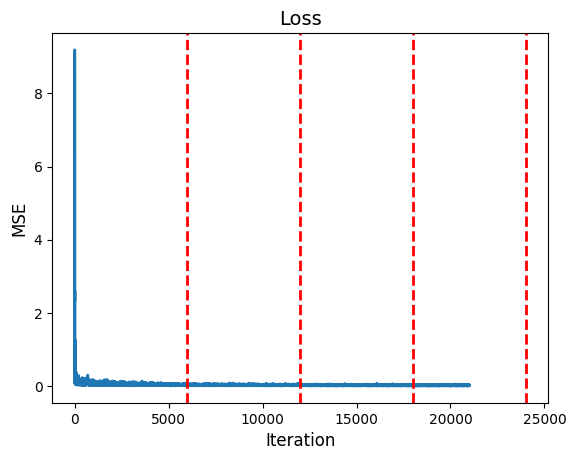

In [7]:
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Loss', fontsize=14)
for e in range(1, epochs):
    plt.axvline(x=e*(N_SIMS/batch_size), color='red', linewidth=2, label='epoch', linestyle='--')
#plt.legend(fontsize=12)
plt.plot()

In [6]:
#Save model
torch.save(model.state_dict(), 'model/model_weights.pth')

In [10]:
X_train.shape

(42000, 102, 1)